# Урок 8. Generative Adversarial Networks

## Домашнее задание

Обучить генератор создавать точки, которые будут лежать на графике функции
y = sin(x)/x - x/10

При выполнении данного задания структура GAN остается той же, но Вам нужно:
1. Сгенерировать настоящие данные
2. Изменить архитектуру дискриминатора и генератора
3. Построить графики

### Подключение библиотек

In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


### Подготовка данных

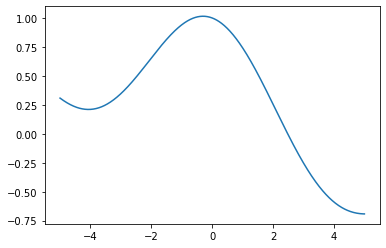

In [3]:
x = np.linspace(-5,5,256*3)

def func_y(x):
    return np.sin(x)/x - x/10

y = func_y(x)

plt.plot(x, y)
plt.show
x_train, y_train = x, y

In [4]:
train = np.array([x_train[0], y_train[0]])
for i in range(1, len(x_train)):
  
  new_arr = [x_train[i], y_train[i]]
  train = np.vstack([train, new_arr])
train[:5]

array([[-5.        ,  0.30821515],
       [-4.98696219,  0.30568473],
       [-4.97392438,  0.30318078],
       [-4.96088657,  0.30070362],
       [-4.94784876,  0.29825357]])

In [5]:
n_epochs = 200
batch_size = 256
lr = 0.0002

b1 = 0.5
b2 = 0.999

hidden_dim = 20

noise_min = -1.0
noise_max = 1.0

In [7]:
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)

In [8]:
SAMPLES_COUNT_IN_DATASET = trainloader.dataset.data.shape[0]
SAMPLES_COUNT_IN_DATASET

768

In [9]:
BATCHES_IN_DATA_COUNT = math.ceil(SAMPLES_COUNT_IN_DATASET / batch_size)
BATCHES_IN_DATA_COUNT

3

### Построение и обучение модели

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(20, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2)
        )

    def forward(self, z):
        img = self.model(z)
        return img


In [12]:
gen_model = Generator().double().to(device)

In [11]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.1, 0.1) 
        nn.init.uniform_(self.bias, -0.1, 0.1) 

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, coords):
        coords_flat = coords.view(coords.size(0), -1)
        validity = self.model(coords_flat)

        return validity

In [15]:
discriminator_model = Discriminator().to(device)

In [16]:
optimizer_G = torch.optim.Adam(gen_model.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator_model.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

[Epoch 200/200] [D loss: 0.691560] [G loss: 0.701796]


<Figure size 432x288 with 0 Axes>

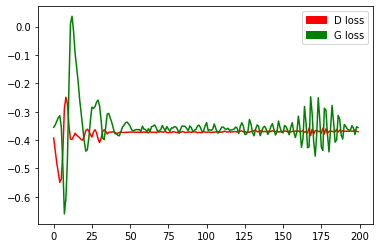

CPU times: user 47.1 s, sys: 1min 12s, total: 1min 59s
Wall time: 2min 51s


In [ ]:
%%time

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

d_loss_history = []
g_loss_history = []

for epoch in range(n_epochs):
    
    generator_epoch_loss = 0.0
    discriminator_epoch_loss = 0.0
    
    for i, data in enumerate(trainloader):


##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)
        
        real_coords = Variable(data.type(torch.FloatTensor)).to(device)

######################  Тренировка генератора    ##########################
        
        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.from_numpy(np.random.uniform(noise_min, noise_max, (batch_size, hidden_dim)).astype(np.float64)).double()).to(device)

        gen_coords = gen_model(z)

        validity = discriminator_model(gen_coords.float())
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        generator_epoch_loss += g_loss.item()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator_model(real_coords.float())
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator_model(gen_coords.detach().float())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        discriminator_epoch_loss += d_loss.item()

######## Отображение процесса обучения и вывод функций потерь ############
        if (i+1) % BATCHES_IN_DATA_COUNT == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            print("[Epoch %d/%d] [D loss: %f] [G loss: %f]"% (epoch+1, n_epochs, discriminator_epoch_loss / BATCHES_IN_DATA_COUNT, generator_epoch_loss / BATCHES_IN_DATA_COUNT)) 

            
            display.display(plt.gcf())
            
            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()

In [ ]:
gen_model.eval()

xx = Variable(torch.from_numpy(np.random.uniform(noise_min, noise_max, (batch_size, hidden_dim)).astype(np.float64)).double()).to(device)

with torch.no_grad():
    test_pred = gen_model(xx)

gen_model.train()

test_pred = test_pred.cpu().detach().numpy()

In [ ]:
count = 0
error = 0.0
for i in range(len(test_pred)):
    xxx = test_pred[i][0]
    y_pred = test_pred[i][1]
    y_real = func_y(xxx)
    
    
    count +=1
    error += abs(y_real - y_pred)

print("\nTotal mean error: %.10f" % (error/count))


Total mean error: 0.0408424319


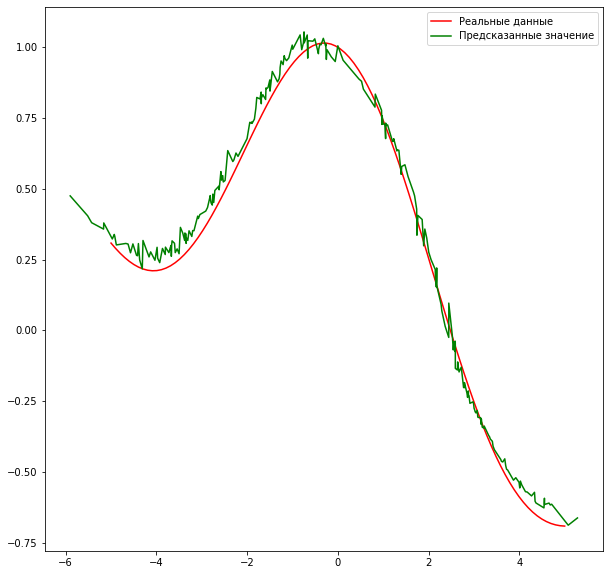

In [ ]:
figure(num=None, figsize=(10, 10))

real_x = np.linspace(-5, 5, 100)
plt.plot(real_x, func_y(real_x), label='Реальные данные', color = 'red')

p = test_pred[:,0].argsort()
plt.plot(test_pred[:,0][p], test_pred[:, 1][p], label='Предсказанные значение', color = 'green')


plt.legend()
plt.show()